In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets, LaTeXStrings  
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, WishartFast

In [3]:
include("UniSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

## Generate data

In [4]:
function generate_data(rng, k, w, zv, yv)
    z_prev = 0.0
    x_prev = 0.0

    z = Vector{Float64}(undef, n)
    v = Vector{Float64}(undef, n)
    x = Vector{Float64}(undef, n)
    y = Vector{Float64}(undef, n)

    for i in 1:n
        z[i] = rand(rng, Normal(z_prev, sqrt(zv)))
        v[i] = exp(k * z[i] + w)
        x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
        y[i] = rand(rng, Normal(x[i], sqrt(yv)))

        z_prev = z[i]
        x_prev = x[i]
    end 
    
    return z, x, y
end

generate_data (generic function with 1 method)

In [5]:
seed = 42

rng = MersenneTwister(seed)

# Parameters of HGF process
real_k = 1.0
real_w = 0.0
z_variance = abs2(0.2)
y_variance = abs2(0.1)

# Number of observations
n = 300

z_true, x_true, y_data = generate_data(rng, real_k, real_w, z_variance, y_variance);
true_function = (x;k=real_k,w=real_w) -> exp(k*x + w) 

#211 (generic function with 1 method)

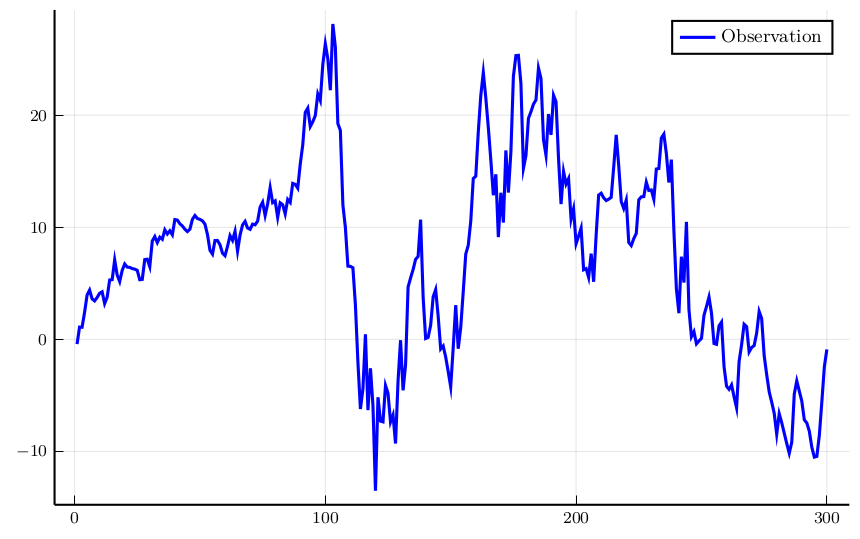

In [6]:
# plot(x_true,label="Latent state",legend=:topright,color=:blue, lw=2,grid=false,fontfamily="monospace",legendfontsize=9)
plot(y_data, label="Observation", lw=1.5,
legend=:topright,color=:blue, fontfamily="monospace",legendfontsize=9)

In [7]:
savefig("texfiles/HGF_synthetic_data.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_synthetic_data.svg"

## Exponential node

In [8]:
## Exponential node 
struct ExpNormal end

@node ExpNormal Stochastic [ y, x, z ]   ## f(y,x,z) = NormalMeanPrecision(y| x, exp(z))

## structured mean field
@rule ExpNormal(:y, Marginalisation) (m_x::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    μ_x, v_x = mean_var(m_x)
    γ = exp(-μ_z + v_z/2)
    return NormalMeanVariance(μ_x, v_x + 1/γ)
end

@rule ExpNormal(:x, Marginalisation) (m_y::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    μ_y, v_y = mean_var(m_y)
    γ = exp(-μ_z + v_z/2)
    return NormalMeanVariance(μ_y, v_y + 1/γ)
end

@marginalrule ExpNormal(:y_x) (m_y::Any, m_x::Any, q_z::Any) = begin
    μ_y, v_y = mean_var(m_y)
    μ_x, v_x = mean_var(m_x)
    μ_z, v_z = mean_var(q_z)
    γ = exp(-μ_z + v_z/2)

    Wm = [μ_y/v_y, μ_x/v_x]
    Wq = [(γ + 1/v_y) -γ;-γ (γ + 1/v_x)]
    return MvNormalWeightedMeanPrecision(Wm, Wq)
end

@rule ExpNormal(:z, Marginalisation) (q_y_x::MultivariateGaussianDistributionsFamily,) = begin
    μ_yx, Σ_yx = mean_cov(q_y_x)
    μ_y, v_yy = μ_yx[1], Σ_yx[1,1]
    μ_x, v_xx = μ_yx[2], Σ_yx[2,2]
    v_yx = Σ_yx[1,2]

    γ2 = μ_y^2 + v_yy - 2*(v_yx + μ_y*μ_x) + μ_x^2 + v_xx
    log_backwardmess = (z) -> -0.5 * z - 0.5 * (1/exp(z)) * γ2
    return ContinuousUnivariateLogPdf(log_backwardmess)
end

@average_energy ExpNormal (q_y_x::Any, q_z::Any) = begin
    μ_yx, Σ_yx = mean_cov(q_y_x)
    μ_y, v_yy = μ_yx[1], Σ_yx[1,1]
    μ_x, v_xx = μ_yx[2], Σ_yx[2,2]
    v_yx = Σ_yx[1,2]
    γ2 = μ_y^2 + v_yy - 2*(v_yx + μ_y*μ_x) + μ_x^2 + v_xx

    μ_z, v_z = mean_var(q_z)
    γ = exp(-μ_z + v_z/2)

    return 0.5 * log(2π) + 0.5 * μ_z + 0.5 * γ * γ2
end


## VMP rule 
@rule ExpNormal(:y, Marginalisation) (q_x::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    return NormalMeanPrecision(mean(q_x), exp(-μ_z + v_z/2))
end

@rule ExpNormal(:x, Marginalisation) (q_y::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    return NormalMeanPrecision(mean(q_y), exp(-μ_z + v_z/2))
end

@rule ExpNormal(:z, Marginalisation) (q_y::Any, q_x::Any) = begin
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)

    log_backwardmess = (z) -> -0.5*z - 0.5 * (1/exp(z)) * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end


@average_energy ExpNormal (q_y::Any, q_x::Any, q_z::Any) = begin
    μ_z, v_z = mean_var(q_z)
    μ_y, v_y = mean_var(q_y)
    μ_x, v_x = mean_var(q_x)
    γ = exp(-μ_z + v_z/2)
    return 0.5*log(2π) + 0.5*μ_z + 0.5* γ * (μ_y^2 + v_y -2*μ_y * μ_x + μ_x^2 + v_x)
end


## Use GCV node

In [9]:
@model function certain_gcv_hgf(y, z_var, y_var)
    z2_prev ~ NormalMeanVariance(0, 50.)
    z1_prev ~ NormalMeanVariance(0, 50.)
    k ~ NormalMeanVariance(1.,0.001)
    w ~ NormalMeanVariance(0.,0.1)

    for i=1:length(y)
        z2[i] ~ NormalMeanVariance(z2_prev,z_var) #upper layer
        z1[i] ~ GCV(z1_prev, z2[i],k , w) ## lower layer
        y[i] ~ NormalMeanVariance(z1[i], y_var)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

@constraints function hgfconstraints() 
    q(z1, z2, z2_prev, z1_prev,k,w) = q(z1,z1_prev)q(z2,z2_prev)q(w)q(k)
end

@meta function hgfmeta()
    GCV() -> GCVMetadata(GaussHermiteCubature(31)) 
end

@initialization function hgf_init()
    q(z1) = NormalMeanVariance(0,20)
    q(z2) = NormalMeanVariance(0,20)
    q(k) = NormalMeanVariance(1.,0.001)
    q(w) = NormalMeanVariance(0.,0.1)
end

hgf_init (generic function with 1 method)

In [10]:
GCV_infer = infer(
    model = certain_gcv_hgf(z_var = z_variance, y_var = y_variance,),
    data = (y = y_data,),
    meta = hgfmeta(),
    constraints = hgfconstraints(),
    initialization = hgf_init(),
    iterations = 300,
    returnvars = (z1 = KeepLast(), z2 = KeepLast(),w=KeepLast(),k=KeepLast(),),
    free_energy = true 
)


Inference results:
  Posteriors       | available for (w, z1, k, z2)
  Free Energy:     | Real[3.44218e5, 6444.17, 658.968, 644.224, 644.291, 644.431, 644.581, 644.731, 644.875, 645.008  …  645.911, 645.911, 645.911, 645.911, 645.911, 645.911, 645.911, 645.911, 645.911, 645.911]


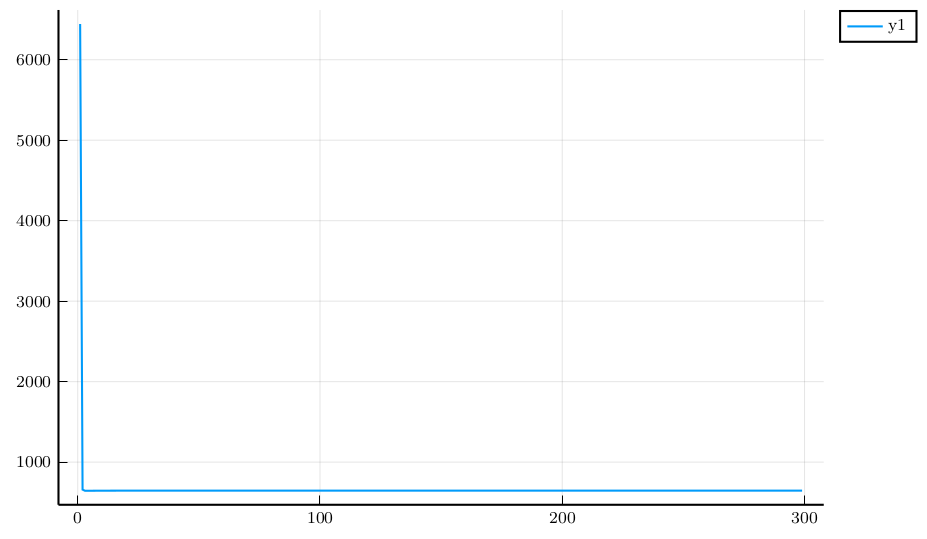

In [11]:
plot(GCV_infer.free_energy[2:end])

In [12]:

qz1_gcv = GCV_infer.posteriors[:z1]
qz2_gcv = GCV_infer.posteriors[:z2]
qw_gcv = GCV_infer.posteriors[:w]
qk_gcv = GCV_infer.posteriors[:k]
;

## Use SGP node 

In [13]:
@model function gp_HFG1(y, z_var, y_var, dim_v,θ)
    z2_prev ~ NormalMeanVariance(0, 50.)
    z1_prev ~ NormalMeanVariance(0, 50.)
    v ~ MvNormalMeanCovariance(zeros(dim_v), 0.01diageye(dim_v))
    w ~ GammaShapeRate(0.01,0.01)

    for i=1:length(y)
        z2[i] ~ NormalMeanVariance(z2_prev,z_var) 
        h[i] ~ UniSGP(z2[i],v,w,θ)
        z1[i] ~ ExpNormal(z1_prev, h[i])
        y[i] ~ NormalMeanVariance(z1[i], y_var)
        z2_prev = z2[i]
        z1_prev = z1[i]
    end
end

@meta function meta_gp_HFG1(method,Xu, kernel)
    UniSGP() -> UniSGPMeta(method,Xu,kernel)
end

gp_constraint = @constraints begin
    q(z1,z2,z1_prev,z2_prev,v,w,h) = q(z1)q(z2)q(z1_prev)q(z2_prev)q(v)q(w)q(h)
    q(z1) = q(z1[begin])..q(z1[end])
    q(z2) = q(z2[begin])..q(z2[end])
end
;

In [14]:
Nu = 25; #number of inducing points 
dim_v = Nu;
Xu = range(-5.,5;length=Nu);
kernel_gp(θ) = θ[1] * with_lengthscale(Matern52Kernel(),θ[2]) 

gp_init = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(dim_v), 0.01diageye(dim_v))
    q(h) = NormalMeanVariance(0,50.)
    q(z1) = NormalMeanVariance(0,50.)
    q(z2) = NormalMeanVariance(0,50.)
    q(w) = GammaShapeRate(0.01,0.01)
end
;

## Optimize hyperparameters

In [15]:
function my_free_energy(θ)

    infer_result = infer(
        model = gp_HFG1(z_var = z_variance, y_var = y_variance,dim_v = dim_v, θ = θ,),
        data = (y = y_data,),
        iterations = 75,
        initialization = gp_init,
        constraints = gp_constraint,
        meta = meta_gp_HFG1(GenUnscented(),Xu,kernel_gp),
        free_energy = true
    )
    return infer_result.free_energy[end]
end

function learn_params(θ,iter)
    lower = [1,1]
    upper = [5,5]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iter))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [16]:
θ_init = [2.,2.5]
θ_optimal = learn_params(θ_init,1)

2-element Vector{Float64}:
 4.5625
 2.5

In [17]:
gp_infer_result = infer(
    model = gp_HFG1(z_var = z_variance, y_var = y_variance,dim_v = dim_v, θ = θ_optimal,),
    data = (y = y_data,),
    iterations = 300,
    initialization = gp_init,
    constraints = gp_constraint,
    meta = meta_gp_HFG1(GenUnscented(),Xu,kernel_gp),
    returnvars = (z1 = KeepLast(),z2 = KeepLast(),h = KeepLast(), v = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


Inference results:
  Posteriors       | available for (w, z1, v, h, z2)
  Free Energy:     | Real[999.561, 953.287, 942.506, 932.076, 921.867, 911.944, 902.368, 893.198, 884.486, 876.276  …  749.572, 749.522, 749.473, 749.426, 749.38, 749.335, 749.291, 749.249, 749.208, 749.168]


In [18]:
qz1_sgp = gp_infer_result.posteriors[:z1]
qz2_sgp = gp_infer_result.posteriors[:z2]
qv_sgp = gp_infer_result.posteriors[:v]
qw_sgp = gp_infer_result.posteriors[:w]
qh_sgp = gp_infer_result.posteriors[:h]
;

## Compare Results

In [22]:
##gp_prediction
function gp_predict(x_test,qv,qw,qθ, meta)
    prediction = @call_rule UniSGP(:out, Marginalisation) (q_in=x_test,q_v = qv, q_w = qw,q_θ = qθ, meta=meta)
    return prediction
end

function gcv_predict(upper_state,qk, qw)
    mz, vz = mean_var(upper_state)
    mk, vk = mean_var(qk)
    zk = NormalMeanVariance(mz * mk, mz^2 * vk + mk^2 * vz + vz * vk)
    return @call_rule typeof(+)(:out, Marginalisation) (m_in1=zk, m_in2 = qw)
end

gcv_predict (generic function with 1 method)

In [23]:
gp_predict_mean =[]
gp_predict_var =[]
for i=1:length(qz2_sgp)
    prediction = gp_predict(qz2_sgp[i],qv_sgp,qw_sgp,PointMass(θ_optimal),UniSGPMeta(GenUnscented(),Xu,kernel_gp))
    append!(gp_predict_mean,mean(prediction))
    append!(gp_predict_var,var(prediction)) 
end

gcv_predict_mean =[]
gcv_predict_var =[]
for i=1:length(qz2_gcv)
    prediction = gcv_predict(qz2_gcv[i],qk_gcv,qw_gcv)
    append!(gcv_predict_mean,mean(prediction))
    append!(gcv_predict_var,var(prediction)) 
end

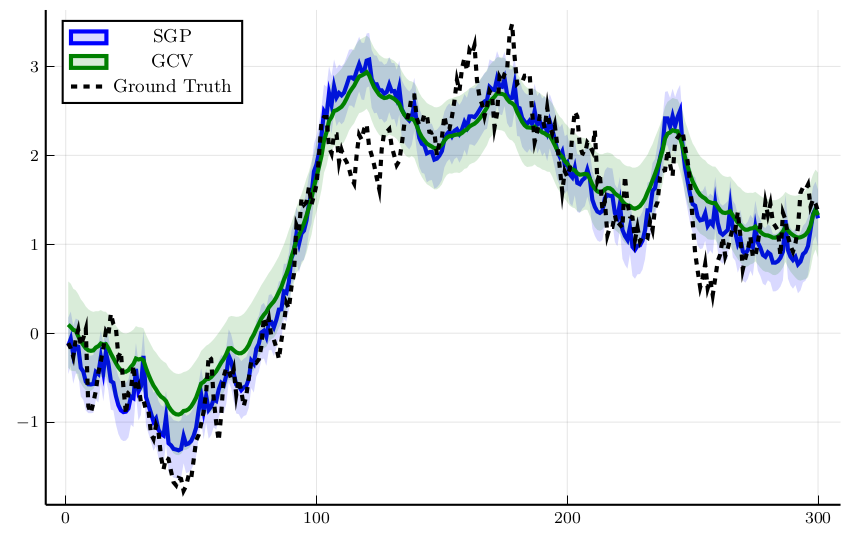

In [24]:
plot(mean.(qh_sgp), ribbon = sqrt.(var.(qh_sgp).+ 1e-7),
    lw=2,
    label = "SGP",
    color=:blue,
    legend=:topleft,
    fontfamily="monospace",legendfontsize=9,
    fillalpha=0.15)

plot!(gcv_predict_mean, ribbon = sqrt.(gcv_predict_var .+ 1e-7),
    lw=2,
    label = "GCV",
    color = :green,
    fillalpha=0.15)

plot!(z_true, label = "Ground Truth", lw=2, ls=:dash, c=:black)

# plot!([collect(2:100),collect(2:100)],
#     [gp_infer_result.free_energy[2:100], GCV_infer.free_energy[2:100]], 
#     label=["SGP" "GCV"],
#     color=[:orange :blue],
#     lw= [1.5 1.5],
#     legend_position=(0.8,0.8),
#     legend_font_pointsize=6,
#     inset = (1, bbox(0.21, 0.1, 0.4, 0.4, :bottom, :right)),
#     xlabel="iterations",
#     ylabel="F[q]",
#     subplot = 2)

In [25]:
savefig("texfiles/HGF_synthetic_comparison.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/HGF_synthetic_comparison.svg"

In [26]:
function rmse_score(y_predict, y_true)
    return sqrt(mean((y_predict - y_true).^2))
end
rmse_GCV_state = rmse_score(z_true, gcv_predict_mean)
rmse_GPnode = rmse_score(z_true, mean.(qh_sgp))
println("The rmse of SGP node: $rmse_GPnode")
println("The rmse of GCV: $rmse_GCV_state")

The rmse of SGP node: 0.41502003988253466
The rmse of GCV: 0.44900359328537354
